In [1]:
import numbers
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
from scipy.spatial import distance
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import seaborn as sns

In [2]:
model_name = "Distancia Euclidiana"

In [3]:
def mili_to_seconds(mls):
    return mls / 1000

def evaluate_AUC(genuine_scores, impostor_scores):
    labels = [0] * len(genuine_scores) + [1] * len(impostor_scores)
    auc_score = roc_auc_score(labels, genuine_scores + impostor_scores)
    return auc_score

def plotCurveROC(genuine_scores, impostor_scores, title = 'Receiver Operating Characteristic', pos_label = 1):
    #Se etiquetan los usuarios legítimos con 1 e impostores con 0
    labels = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    
    #Se utiliza el metodo de roc_curve para hallar los fpr, tpr y umbrales
    fpr, tpr, thresholds = roc_curve(labels, genuine_scores + impostor_scores, pos_label = pos_label)
    
    roc_auc = evaluate_AUC(genuine_scores, impostor_scores)
    
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def pp_array_convert(raw_json_press, raw_json_release):
    parsed_json_press = json.loads(raw_json_press)
    arr = []
    length = len(parsed_json_press)
    for idx in range(length - 1):
        value =  float(parsed_json_press[idx + 1]['timeStamp']) - float(parsed_json_press[idx]['timeStamp'])
        arr.append(value)
    return arr

def rr_array_convert(raw_json_press, raw_json_release):
    parsed_json_release = json.loads(raw_json_release)
    arr = []
    length = len(parsed_json_release)
    for idx in range(length - 1):
        value =  float(parsed_json_release[idx + 1]['timeStamp']) - float(parsed_json_release[idx]['timeStamp'])
        arr.append(value)
    return arr

def pr_array_convert(raw_json_press, raw_json_release):
    parsed_json_press = json.loads(raw_json_press)
    parsed_json_release = json.loads(raw_json_release)
    arr = []
    length = len(parsed_json_press)
    if len(parsed_json_press) != len(parsed_json_release):
        return np.nan
    else:
        for idx in range(length - 1):
            value = float(parsed_json_release[idx + 1]['timeStamp']) - float(parsed_json_press[idx]['timeStamp'])
            arr.append(value)
    return arr

def rp_array_convert(raw_json_press, raw_json_release):
    parsed_json_press = json.loads(raw_json_press)
    parsed_json_release = json.loads(raw_json_release)
    arr = []
    length = len(parsed_json_press)
    if len(parsed_json_press) != len(parsed_json_release):
        return np.nan
    else:
        for idx in range(length - 1):
            value = float(parsed_json_press[idx + 1]['timeStamp']) - float(parsed_json_release[idx]['timeStamp'])
            arr.append(value)
    return arr

def merge_arrays(ppTimeArray, rrTimeArray, prTimeArray, rpTimeArray):
    arr1 = np.array(ppTimeArray)
    arr2 = np.array(rrTimeArray)
    arr3 = np.array(prTimeArray)
    arr4 = np.array(rpTimeArray)
    arr = np.concatenate((arr1, arr2, arr3, arr4))
    return arr

def getVentorLen(passwordLen):
    return (passwordLen - 1) * 4

In [4]:
def euclideanDistance(a, b):
    return distance.euclidean(a.values, b.values)

In [5]:
df = pd.read_csv('./data/11_24/records.csv', parse_dates=['date'])
df.drop(columns=['__v'], inplace = True)

df = df[df.valid == True]

df['ppTime'] = df.apply(lambda x: pp_array_convert(x['rawPasswordKeydown'], x['rawPasswordKeyup']), axis=1)
df['rrTime'] = df.apply(lambda x: rr_array_convert(x['rawPasswordKeydown'], x['rawPasswordKeyup']), axis=1)
df['prTime'] = df.apply(lambda x: pr_array_convert(x['rawPasswordKeydown'], x['rawPasswordKeyup']), axis=1)
df['rpTime'] = df.apply(lambda x: rp_array_convert(x['rawPasswordKeydown'], x['rawPasswordKeyup']), axis=1)

df.dropna(inplace = True)

df['vector'] = df.apply(lambda x: merge_arrays(x['ppTime'], x['rrTime'], x['prTime'], x['rpTime']), axis=1)

df.drop(['sessionIndex','date','rawUsernameKeydown', 'rawUsernameKeyup', 'rawPasswordKeydown', 'rawPasswordKeyup', 'ipAddress', 'userAgent', 'token', 'username'], axis=1, inplace = True)

df['passLen'] = df.apply(lambda x: len(x['password']), axis=1)
df['vectorLen'] = df.apply(lambda x: len(x['vector']), axis=1)

df = df[df['passLen'] == 9]

In [6]:
tempData = []

n_data_rows = df.shape[0]

columns = ["belongedUserId", 'performedUserId', 'vectorLen']

maxlenvector = df['vectorLen'].max()

for i in range(maxlenvector):
    columns.append("ft_" + str(i+1))
    
for i in range(n_data_rows):
    belongedUserId = [df.iloc[i]["belongedUserId"]]
    performedUserId = [df.iloc[i]["performedUserId"]]
    lenVector = [df.iloc[i]["vectorLen"]]
    vector = df.iloc[i]["vector"]
    tempData.append(belongedUserId  + performedUserId + lenVector + list(vector))
    
df = pd.DataFrame(tempData, columns = columns)

features = df.columns[3:35]

for i in range(len(features)):
    col = features[i]
    df[col] = df[col].apply(lambda x: mili_to_seconds(x))

tempData.clear()

### Previsualización de dataset procesado

In [7]:
df

,belongedUserId,performedUserId,vectorLen,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,...,ft_23,ft_24,ft_25,ft_26,ft_27,ft_28,ft_29,ft_30,ft_31,ft_32
0,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,32,0.111995,0.136020,0.080770,0.111070,0.184090,0.127665,0.224095,...,0.320570,0.296165,-0.023985,0.064210,0.000220,-0.031965,0.063690,0.023310,0.119435,0.095770
1,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,32,0.151855,0.185950,0.167610,0.111995,0.536525,0.155055,0.239535,...,0.359090,0.293910,0.065305,0.088070,0.073915,0.015145,0.444885,0.045650,0.132845,0.060495
2,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,32,0.143860,0.159860,0.103765,0.136315,0.199890,0.120935,0.231190,...,0.343695,0.320000,0.008080,0.055555,0.007225,-0.016325,0.071370,0.000170,0.104000,0.103410
3,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,32,0.215815,0.256040,0.168115,0.153190,0.287170,0.119640,0.263930,...,0.368575,0.336010,0.127765,0.175290,0.079795,0.000210,0.168385,0.024080,0.151605,0.119425
4,5f7791082038260004aa67e3,5f778fa22038260004aa67e2,32,0.277640,0.375270,0.310210,0.458315,0.244370,0.205720,0.225345,...,0.293840,0.199525,0.138335,0.270610,0.206560,0.374070,0.139305,0.087080,0.147550,0.094070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9370,5fa9d9dbdd5c300004ce6944,5f7f88895cea9600043a0de7,32,0.225675,0.171235,0.238850,0.105865,0.159220,0.123470,0.943105,...,0.995105,0.388050,0.148630,0.049130,0.160505,0.021450,0.019340,0.062055,0.867550,0.322110
9371,5fa9d9dbdd5c300004ce6944,5f7f88895cea9600043a0de7,32,0.246895,0.092980,0.243445,0.093220,0.155505,0.125410,0.348375,...,0.417040,0.388210,0.167520,-0.018910,0.150815,0.015025,0.008255,0.028805,0.246520,0.256880
9372,5fa9d9dbdd5c300004ce6944,5f7f88895cea9600043a0de7,32,0.252480,0.206950,0.215315,0.109900,0.142960,0.139185,0.353560,...,0.410825,0.414365,0.178225,0.088825,0.127030,0.040400,0.019885,0.063330,0.284790,0.294345
9373,5fa9d9dbdd5c300004ce6944,5f7f88895cea9600043a0de7,32,0.244625,0.188990,0.203285,0.114475,0.131770,0.146080,0.541540,...,0.613995,0.632790,0.163345,0.058210,0.115670,0.034780,0.006645,0.064610,0.471620,0.499410


In [8]:
#Variable que contiene la lista de todos los usuarios de la bd
subjects = df["belongedUserId"].unique()

train_users = []

test_users_g = []

test_users_i_1 = []

test_users_i_2 = []

test_users_i_3 = []


print("User\t\t\t\tTotal_g\tTrain\tTest_g\tTest_i_1\tTest_i_2\tTest_i_3")

for subject in subjects:
    
    #Genuino
    current_user_data = df.loc[(df.belongedUserId == subject) & (df.belongedUserId == df.performedUserId), :]
    
    
    if len(current_user_data) == 0:
        continue
    else:
        train_g, test_g = train_test_split(current_user_data, train_size = 0.80, random_state=43, shuffle=True)

        train_users.append(train_g)

        test_users_g.append(test_g)

        #Impostor
        impostor_data = df.loc[(df.belongedUserId == subject) & (df.belongedUserId != df.performedUserId), :]

        test_i_1, test_i_2 = train_test_split(impostor_data, train_size = 0.33, random_state=43, shuffle=True)

        test_i_2, test_i_3 = train_test_split(test_i_2, train_size = 0.5, random_state=43, shuffle=True)

        test_users_i_1.append(test_i_1)
        test_users_i_2.append(test_i_2)
        test_users_i_3.append(test_i_3)

        print(subject + "\t" + str(current_user_data.shape[0]) + "\t" + str(train_g.shape[0]) + "\t" + str(test_g.shape[0])  +  "\t"+str(test_i_1.shape[0]) +  "\t\t"+str(test_i_2.shape[0]) +  "\t\t"+str(test_i_3.shape[0]))
        
#Se convierte los arrays en dataframes manipulables
train_users = pd.concat(train_users)
test_users_g = pd.concat(test_users_g)
test_users_i_1 = pd.concat(test_users_i_1)
test_users_i_2 = pd.concat(test_users_i_2)
test_users_i_3 = pd.concat(test_users_i_3)

User				Total_g	Train	Test_g	Test_i_1	Test_i_2	Test_i_3
5f778fa22038260004aa67e2	15	12	3	50		51		52
5f7791082038260004aa67e3	93	74	19	59		60		61
5f778b8a2038260004aa67e1	69	55	14	59		60		61
5f77ad3df1051200041f55c7	28	22	6	56		57		58
5f78bfaa46ad0a0004fb32d6	45	36	9	55		56		57
5f77ad46f1051200041f55c8	63	50	13	53		54		55
5f793ce9beeb150004deaac1	23	18	5	61		62		63
5f793dc7beeb150004deab7c	30	24	6	51		52		53
5f793da3beeb150004deab50	42	33	9	61		62		63
5f793de9beeb150004deac04	61	48	13	51		52		53
5f794394beeb150004debf5a	12	9	3	62		63		64
5f7b8d167a63fa000433423a	39	31	8	57		58		59
5f7a813cf57c030004ce8850	60	48	12	51		52		53
5f7c8379859bc10004908e42	16	12	4	57		58		59
5f7c8797859bc10004908f6c	39	31	8	50		51		52
5f7a7d0ef57c030004ce84e4	21	16	5	55		56		57
5f79416cbeeb150004debcd6	24	19	5	60		61		62
5f7cbe979a0c13000426c79e	24	19	5	58		59		60
5f7e56dd748a9400048b1697	54	43	11	58		59		60
5f7e6001748a9400048b1ac5	38	30	8	55		56		57
5f7e8a37a8ebab000498c2ed	26	20	6	59		60		61
5f7e8cbca8ebab0

### Cálculo del vector con la media de cada usuario en el dataset de entrenamiento

In [9]:
train_users.drop(['vectorLen'], axis=1, inplace = True)

#Se calcula la media de cada usuario agrupando el dataframe de train
groupby = train_users.groupby("belongedUserId").mean()

#Se excluye la columna del usuario
train_users = groupby.reset_index()

In [10]:
train_users.head()

,belongedUserId,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,...,ft_23,ft_24,ft_25,ft_26,ft_27,ft_28,ft_29,ft_30,ft_31,ft_32
0,5f778b8a2038260004aa67e1,0.179691,0.149077,0.166540,0.193918,0.132188,0.236077,0.162696,0.162867,0.158889,...,0.225733,0.241373,0.094597,0.084785,0.084793,0.118168,0.026322,0.171980,0.086845,0.099830
1,5f778fa22038260004aa67e2,0.190760,0.236880,0.133187,0.115270,0.580501,0.177370,0.215519,0.252174,0.193380,...,0.309981,0.326010,0.104837,0.148338,0.054372,0.024052,0.502243,0.076671,0.118767,0.157712
2,5f7791082038260004aa67e3,0.159113,0.070350,0.180163,0.114794,0.079472,0.260825,0.220616,0.181084,0.159178,...,0.312995,0.278755,0.040608,-0.048220,0.083916,0.001612,-0.034876,0.151793,0.106242,0.088705
3,5f77ad3df1051200041f55c7,0.186636,0.125273,0.096500,0.322273,0.276818,0.159773,0.223045,0.081045,0.191682,...,0.360409,0.183364,0.097955,0.031545,-0.021000,0.231591,0.187909,0.084500,0.146045,-0.056318
4,5f77ad46f1051200041f55c8,0.757613,0.255917,0.553315,0.468542,0.329262,0.393416,0.424526,0.501624,0.772537,...,0.514558,0.611066,0.667300,0.150681,0.456903,0.375169,0.223801,0.292426,0.316329,0.411592


### ROC usando grupo de impostor 1

In [11]:
users_evaluation_test = []

#Se hace el cálculo para cada usuario
for subject in subjects:
    
    #Media del vector del usuario actual
    mean_vector= train_users.loc[train_users.belongedUserId == subject, "ft_1":"ft_32"]
    
    genuine_data = test_users_g[(test_users_g['belongedUserId'] == subject) & (test_users_g['belongedUserId'] == test_users_g['performedUserId'])]
    
    countGenuineRecords = genuine_data.shape[0]
    
    impostor_data = test_users_i_1[(test_users_i_1['belongedUserId'] == subject) & (test_users_i_1['belongedUserId'] != test_users_i_1['performedUserId'])]#.sample(n= countGenuineRecords, random_state=43)
    
    #Para cada registro del subdataset de test
    for index, row in genuine_data.iterrows():
        temp_obj = {}
        current_user_id = row[1]
        current_data = row[3:]
        temp_obj["user_model"] = subject
        temp_obj["user_id"] = current_user_id
        
        temp_obj["score"] = euclideanDistance(mean_vector, current_data)
        
        if subject == current_user_id:
            temp_obj["y_test"] = "genuine"
        else:
            temp_obj["y_test"] = "impostor"

        users_evaluation_test.append(temp_obj)
        
    for index, row in impostor_data.iterrows():
        temp_obj = {}
        current_user_id = row[1]
        current_data = row[3:]
        temp_obj["user_model"] = subject
        temp_obj["user_id"] = current_user_id
        temp_obj["score"] = euclideanDistance(mean_vector, current_data)
        
        if subject == current_user_id:
            temp_obj["y_test"] = "genuine"
        else:
            temp_obj["y_test"] = "impostor"

        users_evaluation_test.append(temp_obj)

users_evaluation_test = pd.DataFrame(users_evaluation_test)

In [12]:
users_evaluation_test

,user_model,user_id,score,y_test
0,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.336725,genuine
1,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.406473,genuine
2,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.299039,genuine
3,5f778fa22038260004aa67e2,5f77ad46f1051200041f55c8,0.275150,impostor
4,5f778fa22038260004aa67e2,5f778b8a2038260004aa67e1,0.873166,impostor
...,...,...,...,...
2850,5fb80668d564ca0004be334f,5f9058fea84e260004333c12,2.247531,impostor
2851,5fb80668d564ca0004be334f,5f7f72599bd94d00048e68fc,3.959010,impostor
2852,5fb80668d564ca0004be334f,5f7ba68993171a000438bb13,2.430442,impostor
2853,5fb80668d564ca0004be334f,5fa9d9dbdd5c300004ce6944,2.463661,impostor


In [13]:
genuine_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "genuine", "score"])

impostor_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "impostor", "score"])

AUC 1: 0.8170893846063121


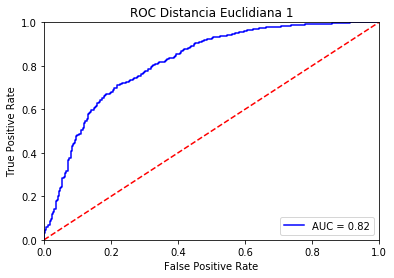

In [14]:
labels = [1] * len(genuine_scores_test) + [0] * len(impostor_scores_test)
fpr_1, tpr_1, thresholds_1 = roc_curve(labels, genuine_scores_test + impostor_scores_test, pos_label = 0)

auc_1 = evaluate_AUC(genuine_scores_test, impostor_scores_test)

print(f'AUC 1: {auc_1}')

#Ploteamos la curva ROC de los umbrales
plotCurveROC( genuine_scores_test, impostor_scores_test, title = f'ROC {model_name} 1', pos_label = 0)

### ROC usando grupo de impostor 2

In [15]:
users_evaluation_test = []

#Se hace el cálculo para cada usuario
for subject in subjects:
    
    #Media del vector del usuario actual
    mean_vector= train_users.loc[train_users.belongedUserId == subject, "ft_1":"ft_32"]
    
    genuine_data = test_users_g[(test_users_g['belongedUserId'] == subject) & (test_users_g['belongedUserId'] == test_users_g['performedUserId'])]
    
    countGenuineRecords = genuine_data.shape[0]
    
    impostor_data = test_users_i_2[(test_users_i_2['belongedUserId'] == subject) & (test_users_i_2['belongedUserId'] != test_users_i_2['performedUserId'])]#.sample(n= countGenuineRecords, random_state=43)
    
    #Para cada registro del subdataset de test
    for index, row in genuine_data.iterrows():
        temp_obj = {}
        current_user_id = row[1]
        current_data = row[3:]
        temp_obj["user_model"] = subject
        temp_obj["user_id"] = current_user_id
        
        temp_obj["score"] = euclideanDistance(mean_vector, current_data)
        
        if subject == current_user_id:
            temp_obj["y_test"] = "genuine"
        else:
            temp_obj["y_test"] = "impostor"

        users_evaluation_test.append(temp_obj)
        
    for index, row in impostor_data.iterrows():
        temp_obj = {}
        current_user_id = row[1]
        current_data = row[3:]
        temp_obj["user_model"] = subject
        temp_obj["user_id"] = current_user_id
        temp_obj["score"] = euclideanDistance(mean_vector, current_data)
        
        if subject == current_user_id:
            temp_obj["y_test"] = "genuine"
        else:
            temp_obj["y_test"] = "impostor"

        users_evaluation_test.append(temp_obj)

users_evaluation_test = pd.DataFrame(users_evaluation_test)

In [16]:
users_evaluation_test

,user_model,user_id,score,y_test
0,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.336725,genuine
1,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.406473,genuine
2,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.299039,genuine
3,5f778fa22038260004aa67e2,5f76d9e492fecb0004a0f543,0.638377,impostor
4,5f778fa22038260004aa67e2,5f9058fea84e260004333c12,0.976322,impostor
...,...,...,...,...
2900,5fb80668d564ca0004be334f,5f7791082038260004aa67e3,1.614480,impostor
2901,5fb80668d564ca0004be334f,5f862e2cdb919500043c02d9,1.222956,impostor
2902,5fb80668d564ca0004be334f,5f7e56dd748a9400048b1697,2.551310,impostor
2903,5fb80668d564ca0004be334f,5f862e2cdb919500043c02d9,2.415718,impostor


In [17]:
genuine_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "genuine", "score"])

impostor_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "impostor", "score"])

AUC 2: 0.8245950301969044


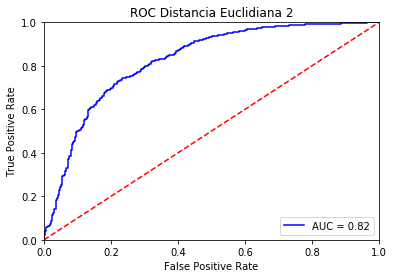

In [18]:
labels = [1] * len(genuine_scores_test) + [0] * len(impostor_scores_test)
fpr_2, tpr_2, thresholds_2 = roc_curve(labels, genuine_scores_test + impostor_scores_test, pos_label = 0)

auc_2 = evaluate_AUC(genuine_scores_test, impostor_scores_test)

print(f'AUC 2: {auc_2}')

#Ploteamos la curva ROC de los umbrales
plotCurveROC( genuine_scores_test, impostor_scores_test, title = f'ROC {model_name} 2', pos_label = 0)

### ROC usando grupo de impostor 3

In [19]:
users_evaluation_test = []

#Se hace el cálculo para cada usuario
for subject in subjects:
    
    #Media del vector del usuario actual
    mean_vector= train_users.loc[train_users.belongedUserId == subject, "ft_1":"ft_32"]
    
    genuine_data = test_users_g[(test_users_g['belongedUserId'] == subject) & (test_users_g['belongedUserId'] == test_users_g['performedUserId'])]
    
    countGenuineRecords = genuine_data.shape[0]
    
    impostor_data = test_users_i_3[(test_users_i_3['belongedUserId'] == subject) & (test_users_i_3['belongedUserId'] != test_users_i_3['performedUserId'])]#.sample(n= countGenuineRecords, random_state=43)
    
    #Para cada registro del subdataset de test
    for index, row in genuine_data.iterrows():
        temp_obj = {}
        current_user_id = row[1]
        current_data = row[3:]
        temp_obj["user_model"] = subject
        temp_obj["user_id"] = current_user_id
        
        temp_obj["score"] = euclideanDistance(mean_vector, current_data)
        
        if subject == current_user_id:
            temp_obj["y_test"] = "genuine"
        else:
            temp_obj["y_test"] = "impostor"

        users_evaluation_test.append(temp_obj)
        
    for index, row in impostor_data.iterrows():
        temp_obj = {}
        current_user_id = row[1]
        current_data = row[3:]
        temp_obj["user_model"] = subject
        temp_obj["user_id"] = current_user_id
        temp_obj["score"] = euclideanDistance(mean_vector, current_data)
        
        if subject == current_user_id:
            temp_obj["y_test"] = "genuine"
        else:
            temp_obj["y_test"] = "impostor"

        users_evaluation_test.append(temp_obj)

users_evaluation_test = pd.DataFrame(users_evaluation_test)

In [20]:
users_evaluation_test

,user_model,user_id,score,y_test
0,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.336725,genuine
1,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.406473,genuine
2,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.299039,genuine
3,5f778fa22038260004aa67e2,5f7b4cb1b41039000475a738,0.328687,impostor
4,5f778fa22038260004aa67e2,5f7c8379859bc10004908e42,0.996182,impostor
...,...,...,...,...
2950,5fb80668d564ca0004be334f,5f793da3beeb150004deab50,3.025220,impostor
2951,5fb80668d564ca0004be334f,5f862e2cdb919500043c02d9,2.074507,impostor
2952,5fb80668d564ca0004be334f,5f793da3beeb150004deab50,3.683174,impostor
2953,5fb80668d564ca0004be334f,5f7e56dd748a9400048b1697,2.967065,impostor


In [21]:
genuine_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "genuine", "score"])

impostor_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "impostor", "score"])

AUC 3: 0.8257303695448025


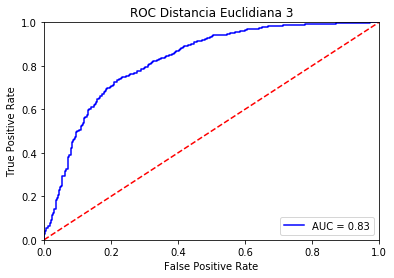

In [22]:
labels = [1] * len(genuine_scores_test) + [0] * len(impostor_scores_test)
fpr_3, tpr_3, thresholds_3 = roc_curve(labels, genuine_scores_test + impostor_scores_test, pos_label = 0)

auc_3 = evaluate_AUC(genuine_scores_test, impostor_scores_test)

print(f'AUC 3: {auc_3}')

#Ploteamos la curva ROC de los umbrales
plotCurveROC( genuine_scores_test, impostor_scores_test, title = f'ROC {model_name} 3', pos_label = 0)

### Las 3 curvas ROC de los 3 subdatasets de prueba

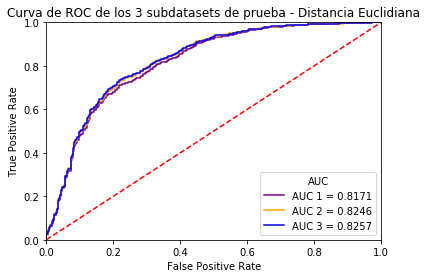

In [23]:
plt.figure()

plt.title(f'Curva de ROC de los 3 subdatasets de prueba - {model_name}')

plt.plot(fpr_1, tpr_1, 'purple', label = 'AUC 1 = %0.4f' % auc_1)

plt.plot(fpr_2, tpr_2, 'orange', label = 'AUC 2 = %0.4f' % auc_2)

plt.plot(fpr_3, tpr_3, 'blue', label = 'AUC 3 = %0.4f' % auc_3)

#------------------------------------------------------------------
#Configuraciones generales
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(title='AUC', loc = 'lower right')
plt.show()